<br>

## Loading libraries

In [2]:
# core
import gym
import wandb
import numpy as np
from tqdm import tqdm

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans

wandb.login();

wandb: Currently logged in as: vinas (use `wandb login --relogin` to force relogin)


<br>
<br>
<br>

## Setting up wandb environment

In [2]:
# Training environment initialisations
PARAMS = {
    'algo': 'Q_learning', # SARSA or Q_learning
    'n_states': 40,
    'episodes': 5000,
    'max_steps': 3000,
    'initial_lr': 0.1,
    'min_lr': 0.005,
    'J': 100,
    'gamma': 0.99,
    'epsilon': 0.05,
    'seed': 17
}       


wandb.init(project='MountainCarProblem', config=PARAMS, reinit=True)
wandb.save('./3_online_ql_sarsa.ipynb')
PARAMS = wandb.config

</br>
</br>

## Creating and Exploring the environment

In [3]:
env_name = 'MountainCar-v0'
env = gym.make(env_name).unwrapped
env_low = env.observation_space.low
env_high = env.observation_space.high

</br>
</br>

## Exploring and learning from the environment

In [4]:
def RBF_transform(state_act, kmeans_centres, sig):
    # Executing an RBF transform over a state-action combination
    return np.exp(-np.linalg.norm(state_act - kmeans_centres, axis=1)/sig)

def get_values(state_acts, w, kmeans_centres, sig):
    # Predicting the values of given state-action combinations
    u = np.array(list(map(lambda x: RBF_transform(x, kmeans_centres, sig), state_acts)))
    return u@w

def choose_action(values, epsilon):
    if np.random.uniform(low=0, high=1) < epsilon:
        a = env.action_space.sample()
    else:
        a = np.argmax(values)
    return a

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

def get_kcentres(env, PARAMS):
    
    # Creating a design matrix from all possible state-action combinations
    ls = np.linspace(env_low, env_high, PARAMS['n_states']).T
    X = np.array(np.meshgrid(ls[0], ls[1], range(env.action_space.n))).T.reshape(-1,3).round(3)

    actions = X[:,2].astype(int)
    onehot_actions = np.eye(env.action_space.n)[actions]
    X = np.concatenate((X[:,:2], onehot_actions), axis=1)

    # Finding J centres and the standard deviation
    sig = np.std(X)
    kmeans_centres = KMeans(n_clusters=PARAMS['J'], random_state=PARAMS['seed']).fit(X).cluster_centers_

    return kmeans_centres, sig

def get_lrates(PARAMS, p):
    
    # Scheduling the learning rate
    x = np.log(PARAMS['min_lr']/PARAMS['initial_lr']) / np.log(PARAMS['gamma'])
    powers = np.linspace(0, x, PARAMS['episodes'])
    powers = np.floor(powers/p)*p
    l_rates = PARAMS['initial_lr']*(PARAMS['gamma']**powers)

    plt.plot(l_rates)
    plt.grid()
    plt.title('Stepped, exponentially decaying learning rate')
    sns.despine()
    
    return l_rates

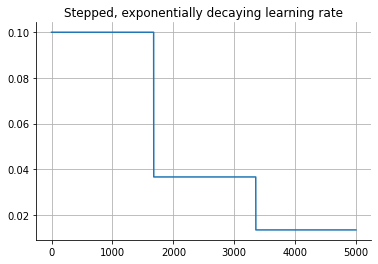

In [5]:
kmeans_centres, sig = get_kcentres(env, PARAMS)
l_rates = get_lrates(PARAMS, 100)

<img src='sarsa_algo.png'>

In [6]:
w = np.zeros(PARAMS['J'])
done_count = 0
breaker = 0

render = False
pbar = tqdm(range(PARAMS['episodes']))
for episode in pbar:
    if breaker==1: break
    
    # [1] Reseting the environment and adjusting the learning rate
    pos, vel = env.reset()
    a = env.action_space.sample()
    alpha = l_rates[episode]
    wandb.log({'lr': alpha}, step=episode)
    
    # [2] Initiating the agent
    steps = 0
    while True:
        if render: env.render()
            
        steps += 1
            
        # [3] Predicting the value of the state-action before taking a step and calculating the gradient
        state_act = np.array([[pos, vel, 0, 0, 0]]); state_act[0, a+2] = 1
        q = get_values(state_act, w, kmeans_centres, sig)
        q_grad = RBF_transform(state_act, kmeans_centres, sig)
        
        # [4] Taking the action, receiving a reward
        (pos_, vel_), reward, done, _ = env.step(a)
        
        if done:
            done_count += 1
            wandb.log({'steps': steps}, step=episode)
            w += alpha*(reward - q)*q_grad 
            break
            
        # [5] Predicting the values of all state-actions
        state_acts = np.concatenate([np.repeat([[pos_, vel_]], env.action_space.n, axis=0),
                                     np.eye(env.action_space.n)], axis=1)
        values = get_values(state_acts, w, kmeans_centres, sig)
        
        # [6] Choosing an action
        a_ = choose_action(values, PARAMS['epsilon'])        
        if PARAMS['algo']=='SARSA':
            q_ = values[a_]
        elif PARAMS['algo']=='Q_learning':
            q_ = values.max()
        else:
            print('invalid algo chosen')
            breaker = 1
            break
        
        # [7] Updating the weights
        w += alpha*(reward + PARAMS['gamma']*q_ - q)*q_grad
        
        # [8] Storing state-action values for the next step
        pos, vel, a = pos_, vel_, a_
        
        if steps>=PARAMS['max_steps']:
            wandb.log({'steps': steps}, step=episode)
            break

             
    pbar.set_postfix(done_count=done_count, steps_taken=steps)

np.save('./weights', w)
wandb.save('./weights.npy');

100%|██████████| 5000/5000 [12:31<00:00,  6.66it/s, done_count=4777, steps_taken=238] 


<br>
<br>
<br>

## Plotting the runs

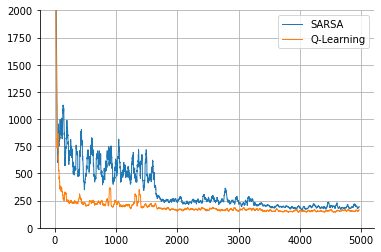

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sarsa = wandb.Api().run(f'/MountainCarProblem/29tsllke').history(samples=5000)
qlearn = wandb.Api().run(f'/MountainCarProblem/1o61c32z').history(samples=5000)

def left(ax=ax):
    
    ax.plot(moving_average(sarsa['steps'], 30), label='SARSA', linewidth=1)
    ax.plot(moving_average(qlearn['steps'], 30), label='Q-Learning', linewidth=1)
    ax.set_ylim([0, 2000])
    ax.grid()
    ax.legend()    
    

left()
sns.despine()

plt.savefig('./Plots/sarsa_ql.png', bbox_inches='tight', pad_inches=0.1)

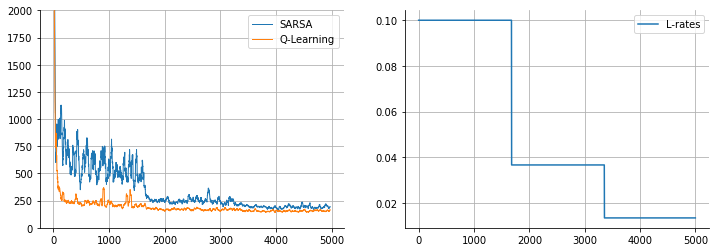

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sarsa = wandb.Api().run(f'/MountainCarProblem/29tsllke').history(samples=5000)
qlearn = wandb.Api().run(f'/MountainCarProblem/1o61c32z').history(samples=5000)

def left(ax=ax[0]):
    
    ax.plot(moving_average(sarsa['steps'], 30), label='SARSA', linewidth=1)
    ax.plot(moving_average(qlearn['steps'], 30), label='Q-Learning', linewidth=1)
    ax.set_ylim([0, 2000])
    ax.grid()
    ax.legend()
    
def right(ax=ax[1]):
    
    ax.plot(sarsa['lr'], label='L-rates')
    ax.grid()
    ax.legend()
    
    

left()
right()
sns.despine()